# EDA - Spotify Song Prediction: Hit or Flop?

The following dataset was taken from https://www.kaggle.com/theoverman/the-spotify-hit-predictor-dataset.

The data consists of various csv files which contain song records from each decade: 60s, 70s, 80s, 90s, 00s, and 10s. For this project, all files were combined to create on dataset.

The author of the dataset used Spotify's API (spotipy) to fetch data and created a series of features for each song, including speechiness, acousticness, liveness, loundness tempo, and duration.

The task is to try and predict the target (1 or 0) if the song is a hit (1) or flop (0). "Hit" is determined if the song was featured in the weekly Hot-100 tracks issued by Billboards within it's respective decade at least once.

In [112]:
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os


#create a file with data from all eras

#df with empty data frame
df = pd.DataFrame() 
#loop to read all datasets and append them to empty dataframe 
for root, dirs, filenames in os.walk('./data'):
    for f in filenames:
        if f.endswith('.csv'):
            df_temp = pd.read_csv(root + '/' + f)
            df_temp['decade'] = f[11:14]
            df = pd.concat([df, df_temp])


#convert duration to minutes
df['duration_min'] = df['duration_ms'] /1000/60
df = df.drop(columns=['duration_ms'])

## Understanding The Data

Data Dictionary - definitions taken directly from author on kaggle.

<style type="text/css">
	table.tableizer-table {
		font-size: 12px;
		border: 1px solid #CCC; 
		font-family: Arial, Helvetica, sans-serif;
	} 
	.tableizer-table td {
		padding: 4px;
		margin: 3px;
		border: 1px solid #CCC;
	}
	.tableizer-table th {
		background-color: #104E8B; 
		color: #FFF;
		font-weight: bold;
	}
</style>
<table class="tableizer-table">
<thead><tr class="tableizer-firstrow"><th>Variable</th><th>Definition</th></tr></thead><tbody>
 <tr><td>track</td><td>Track name</td></tr>
 <tr><td>artist</td><td>Artist name</td></tr>
 <tr><td>uri</td><td>Resource identifier for the track.</td></tr>
 <tr><td>danceability</td><td>Range from 0 to 1. 0 = least danceable, 1 = most danceable</td></tr>
 <tr><td>energy</td><td>Range from 0 to 1. 0 = least energetic, 1 = most energetic </td></tr>
 <tr><td>key</td><td>Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C?/D?, 2 = D, and so on. If no key was detected, the value is -1.</td></tr>
 <tr><td>loudness</td><td>Measured in decibals (dbs). Typica range between -60 & 0 db. </td></tr>
 <tr><td>mode</td><td>Modality (major or minor)l. 1= Major, 0 = Minor</td></tr>
 <tr><td>speechiness</td><td>Ranges from 0 to 1, 0 represents no speech.</td></tr>
 <tr><td>acousticness</td><td>Ranges from 0 to 1. Acoustic song probability. </td></tr>
 <tr><td>instrumentalness</td><td>Ranges from 0 to 1, 1 respesents almost no vocals.</td></tr>
 <tr><td>liveness</td><td>Ranges from 0 to 1. Live track probability.</td></tr>
 <tr><td>valence</td><td>Range from 0 to 1. Happier/positive closer to 1.</td></tr>
 <tr><td>tempo</td><td>Estimated tempo of a track in BPM.</td></tr>
 <tr><td>duration_ms</td><td>Duration of track (miliseconds).</td></tr>
 <tr><td>time_signature</td><td>Estimated overall time signature of a track.</td></tr>
 <tr><td>chorus_hit</td><td>Estimate of when the chorus would start for the track.</td></tr>
 <tr><td>sections</td><td>The number of sections the particular track has. </td></tr>
 <tr><td>target</td><td>0 = Flop, 1 = Hit</td></tr>
</tbody></table>

### What are the different data types I'm working with?

Most of the data features are expressed as a float64 (continuous variable) - majority of the features are expressed on as scale from 0 to 1 (e.g. energy, danceability, valence).

Important to note that mode and key should be considered categorical variables despite being expressed as an integer. Key is converted to pitch class. Mode uses 0 to represent songs in a minor key, 1 to represent songs in a major key.

In [113]:

pd.DataFrame(df.dtypes, columns=['DataType'])

,DataType
track,object
artist,object
uri,object
danceability,float64
energy,float64
key,int64
loudness,float64
mode,int64
speechiness,float64
acousticness,float64


## Initial Dataset Preview

In [114]:
df.sample(5)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,chorus_hit,sections,target,decade,duration_min
1179,United States Of Whatever,Liam Lynch,spotify:track:6Jub05dvpbF4Im83NqMCUg,0.452,0.817,7,-2.270,1,0.2730,0.00383,0.000000,0.1380,0.867,161.362,4,45.74745,4,0,00s,1.520450
2997,"Live, Laugh, Love",Clay Walker,spotify:track:3Th5HBAlRZF0oN31ubxHA9,0.647,0.746,2,-10.597,1,0.0437,0.19500,0.000000,0.0271,0.946,98.991,4,27.97003,11,1,90s,4.104450
5625,What It Feels Like For A Girl,Madonna,spotify:track:6rQcK4xOzePDdrTg7Yv6d6,0.670,0.627,8,-9.497,1,0.0478,0.20100,0.001610,0.1540,0.582,104.988,4,36.89610,11,1,00s,4.731550
3272,Sunken Shrine,Nobuo Uematsu,spotify:track:0cWMrsG0DXY9ztDqU2crGy,0.610,0.452,8,-14.939,0,0.0450,0.82900,0.914000,0.1740,0.883,134.964,4,28.85362,7,0,80s,1.691783
868,Let Me Know (I Have A Right),Gloria Gaynor,spotify:track:29ok4nWfUmmR1A8P8t2kuq,0.789,0.735,11,-8.292,0,0.0384,0.01430,0.000082,0.3000,0.925,126.785,4,14.55440,10,1,70s,3.248883


#### How much data is there to work with? 

In [115]:
df.shape

(41106, 20)

#### Are there any duplicates in this dataset?

In [116]:
#remove duplicates based on the unique identifier from spotify, uri.
df = df.drop_duplicates(subset = 'uri')

In [117]:
df.shape

(40560, 20)

#### Dataset looks balanced - even split between "flops" and "hits"

In [118]:
df.target.value_counts()

0    20540
1    20020
Name: target, dtype: int64

In [119]:
df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,chorus_hit,sections,target,duration_min
count,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000,40560.000000
mean,0.538791,0.578632,5.213240,-10.247409,0.692998,0.072988,0.365995,0.156192,0.201770,0.541591,119.325267,3.892825,40.133580,10.470587,0.493590,3.912317
std,0.177907,0.253198,3.532852,5.326406,0.461256,0.086183,0.339686,0.304890,0.173249,0.267556,29.123819,0.424453,19.042756,4.893720,0.499965,1.992413
min,0.000000,0.000251,0.000000,-49.253000,0.000000,0.000000,0.000000,0.000000,0.013000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.252800
25%,0.419000,0.394000,2.000000,-12.847000,0.000000,0.033700,0.039500,0.000000,0.094100,0.329000,97.340250,4.000000,27.617023,8.000000,0.000000,2.875888
50%,0.551000,0.600000,5.000000,-9.282000,1.000000,0.043500,0.261000,0.000126,0.132000,0.557000,117.523000,4.000000,35.854740,10.000000,0.000000,3.626000
75%,0.668000,0.787000,8.000000,-6.390000,1.000000,0.069900,0.679250,0.066100,0.261250,0.767000,136.532250,4.000000,47.659550,12.000000,1.000000,4.443117
max,0.988000,1.000000,11.000000,3.744000,1.000000,0.960000,0.996000,1.000000,0.999000,0.996000,241.423000,5.000000,433.182000,169.000000,1.000000,69.503783


## Correlations

#### Are there any correlations that stick out between features and our target?

In [120]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,chorus_hit,sections,target,duration_min
danceability,1.000000,0.204813,0.015420,0.274197,-0.031620,0.156821,-0.259344,-0.302239,-0.114108,0.553765,-0.064839,0.191221,-0.035747,-0.060357,0.346264,-0.064396
energy,0.204813,1.000000,0.023114,0.772999,-0.033154,0.121979,-0.716148,-0.207888,0.158197,0.340691,0.224936,0.196164,0.010788,-0.040705,0.175857,0.011525
key,0.015420,0.023114,1.000000,0.008950,-0.140057,0.025646,-0.024421,-0.013705,0.000743,0.008810,0.001028,0.004324,0.010107,0.006131,0.010133,0.014365
loudness,0.274197,0.772999,0.008950,1.000000,0.000630,0.069117,-0.566823,-0.374053,0.087437,0.272587,0.170619,0.165513,-0.011981,-0.080856,0.284353,-0.050425
mode,-0.031620,-0.033154,-0.140057,0.000630,1.000000,-0.059164,0.049601,-0.076395,0.008888,0.037120,0.027437,-0.008883,-0.022569,-0.056790,0.079776,-0.074646
speechiness,0.156821,0.121979,0.025646,0.069117,-0.059164,1.000000,-0.083767,-0.084773,0.131465,0.001127,0.036644,0.020474,0.012854,-0.009075,-0.040676,0.007267
acousticness,-0.259344,-0.716148,-0.024421,-0.566823,0.049601,-0.083767,1.000000,0.203162,-0.031820,-0.194733,-0.181123,-0.187827,-0.013215,-0.015966,-0.244019,-0.069350
instrumentalness,-0.302239,-0.207888,-0.013705,-0.374053,-0.076395,-0.084773,0.203162,1.000000,-0.051379,-0.288135,-0.054049,-0.077441,0.048229,0.081797,-0.405741,0.107171
liveness,-0.114108,0.158197,0.000743,0.087437,0.008888,0.131465,-0.031820,-0.051379,1.000000,0.001014,0.024474,0.006057,0.037610,-0.011600,-0.050676,0.005629
valence,0.553765,0.340691,0.008810,0.272587,0.037120,0.001127,-0.194733,-0.288135,0.001014,1.000000,0.108990,0.155731,-0.059129,-0.134115,0.251363,-0.172830


Text(0, 0.5, 'Song Feature')

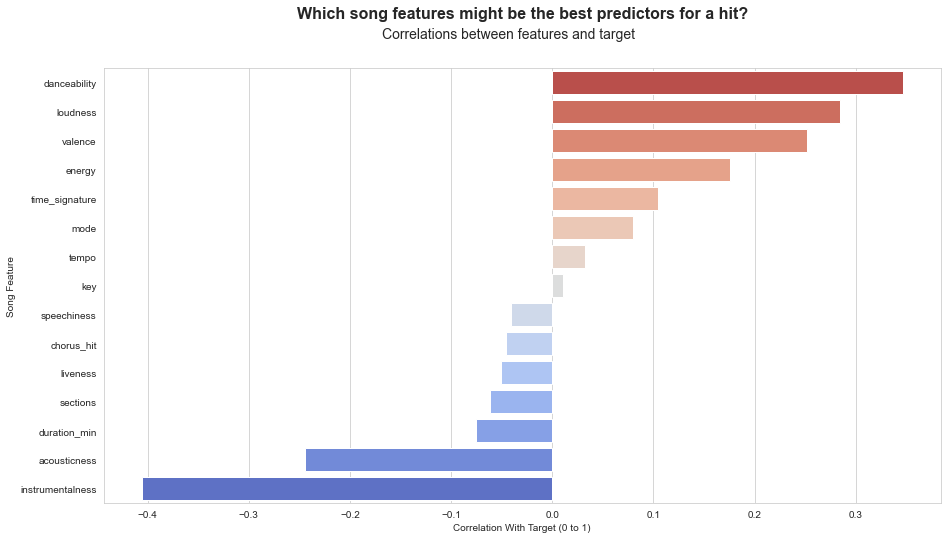

In [123]:
plot_corr = corr['target'].sort_values(ascending=False).to_frame()

plot_corr

plot_corr['feature'] = plot_corr.index

#remove target from features list
plot_corr = plot_corr[plot_corr['feature']!="target"]

plt.figure(figsize=(15,8))
plt.title('Which song features might be the best predictors for a hit?', fontsize=16, fontweight='bold', y =1.1)
plt.suptitle('Correlations between features and target',fontsize=14, y=0.95)
sns.set_style("whitegrid")
ax = sns.barplot(x='target', y='feature', palette = "coolwarm_r", data=plot_corr)
ax.set_xlabel('Correlation With Target (0 to 1)')
ax.set_ylabel('Song Feature')

### Did music tastes change over time?

#### Feature Correlations with Target by Decade

In [124]:
decades = ['60s','70s','80s','90s','00s','10s']

d = []
for i in decades:
    df_decade = df[df.decade == i]
    df_decade_corr = df_decade.corr()
    plot_corr_decade = df_decade_corr['target'].sort_values(ascending=False).to_frame()
    plot_corr_decade['feature'] = plot_corr_decade.index
    plot_corr_decade = plot_corr_decade[plot_corr_decade['feature']!="target"]
    plot_corr_decade['decade'] = i
    d.append(plot_corr_decade)
new_df = pd.concat(d)
    #print(plot_corr_decade)
    
new_df
#create pivot to create columns by decade
new_df = new_df.pivot(index='feature', columns='decade', values='target')

#reindex
new_df = new_df.reindex(decades, axis=1)

new_df
new_df.style.background_gradient(cmap='coolwarm')

decade,60s,70s,80s,90s,00s,10s
feature,,,,,,
acousticness,-0.275397,-0.289278,-0.290471,-0.375397,-0.224062,-0.182183
chorus_hit,-0.015196,-0.025576,-0.023185,-0.049155,-0.091396,-0.080377
danceability,0.236793,0.275142,0.348707,0.454094,0.457600,0.388137
duration_min,-0.178877,-0.042045,0.020075,0.072870,-0.138670,-0.192142
energy,0.298936,0.242181,0.184764,0.220702,0.086555,0.056241
instrumentalness,-0.329258,-0.369947,-0.385171,-0.426885,-0.468409,-0.496024
key,0.019508,-0.021240,0.015230,0.054618,-0.005762,0.006120
liveness,0.033872,-0.035487,-0.097707,-0.101958,-0.076467,-0.064451
loudness,0.315767,0.262928,0.248021,0.335003,0.348689,0.324235


#### Feature Variability by Decade - BoxPlots

In [125]:
#Set Default Color Palette
all_pal = '#39393A'
hit_pal ='#D81E5B'
flop_pal = 'grey'

def plot_box_decade(var_feature):
    df
    fig, ax = plt.subplots(1,2, figsize=(18,5))
    sns.boxplot(x="decade", y=var_feature, data=df, order = decades, palette="Blues", ax=ax[0]).set_title('By Decade')
    sns.boxplot(x="decade", y=var_feature, hue= "target", palette = [flop_pal, hit_pal], data=df, order = decades, ax=ax[1]).set_title('By Decade: Hit vs. Flop')
    plt.legend()
    fig.suptitle(var_feature)
    

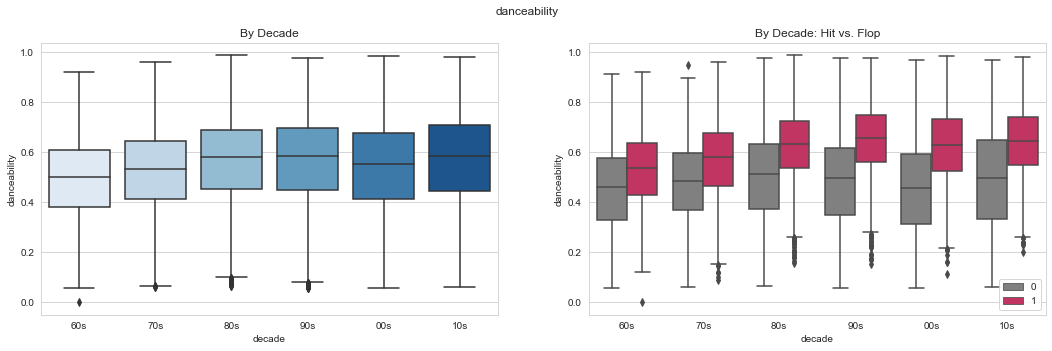

In [126]:
plot_box_decade("danceability")

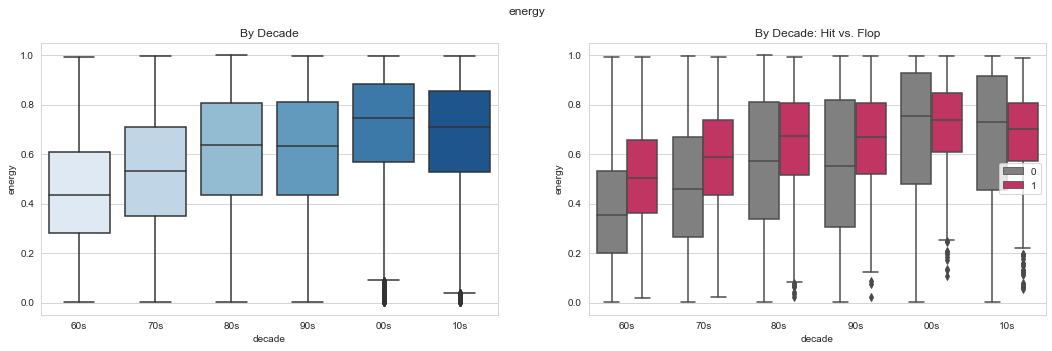

In [127]:
plot_box_decade("energy")

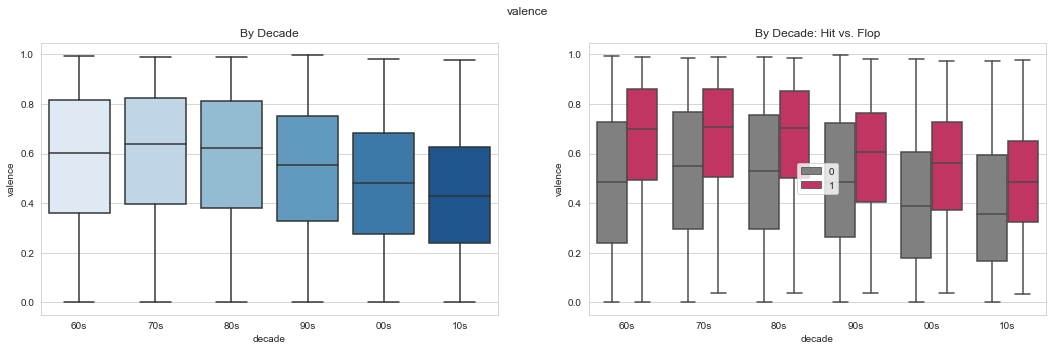

In [128]:
plot_box_decade("valence")

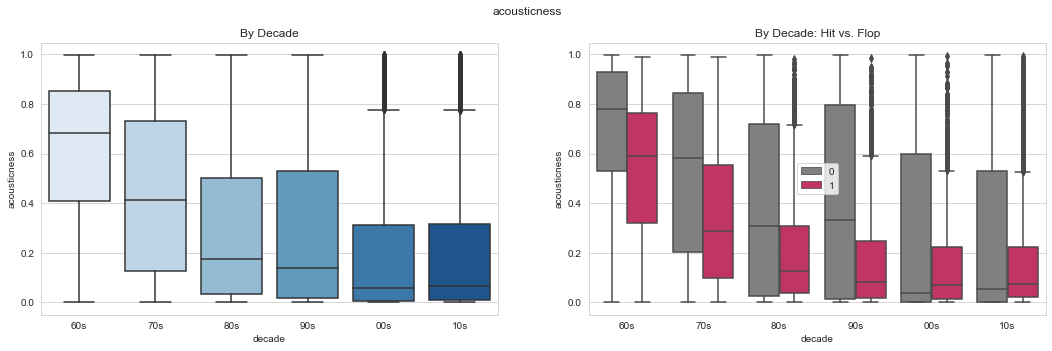

In [129]:
plot_box_decade("acousticness")

<b> Correlations Notes: </b>
    
Danceability, Valence, Loduness, and Energy look like strong positive influencers of song hit prediction.

Instrumentalness, Acousticness, Speechiness, and Liveness look like negative influencers of song hit prediction.

## Feature Analysis

### Distributions for Continuous Features - All Songs & Hits vs. Flops

Continuous features include: Danceability, Energy, Loudness, Speechiness, Instrumentalness, Acousticness, Liveness, Valence

Create function to plot distributions for continuous variables. Create two subplots, one to look at distribution of variable across the entires dataset (All Songs), and one to compare distribution of Flops (Target = 0) vs. Hits (Target = 1).

In [130]:
#Set Default Color Palette
all_pal = '#39393A'
hit_pal ='#D81E5B'
flop_pal = 'grey'

#Create a function to plot all policy data vs. policies with claims data based on selected attribute
def plot_histogram(var_feature):
    df
    hits = df[df['target'] == 1]
    flops = df[df['target'] == 0]
   # fig, ax = plt.subplots(figsize=(20, 10))
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    sns.distplot(df[var_feature], color=all_pal,ax=ax[0]).set(title='All Songs')
    sns.distplot(flops[var_feature], color=flop_pal, label="Flops", ax=ax[1]).set(title='Hits')
    sns.distplot(hits[var_feature], color=hit_pal, label="Hits", ax=ax[1]).set(title="Hits vs. Flops")
    plt.legend()
    fig.suptitle(var_feature)


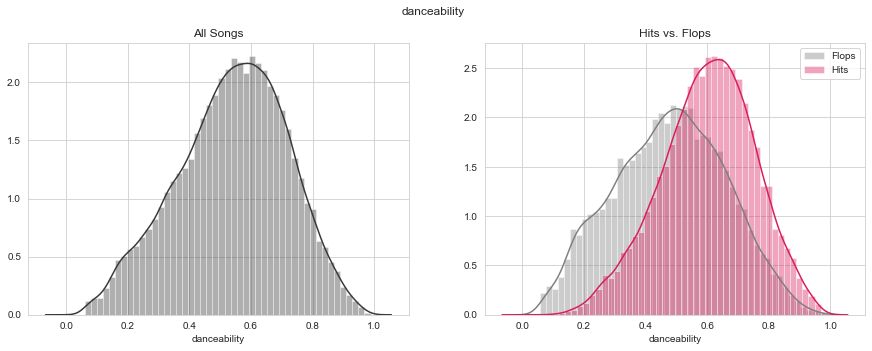

In [131]:
plot_histogram('danceability')

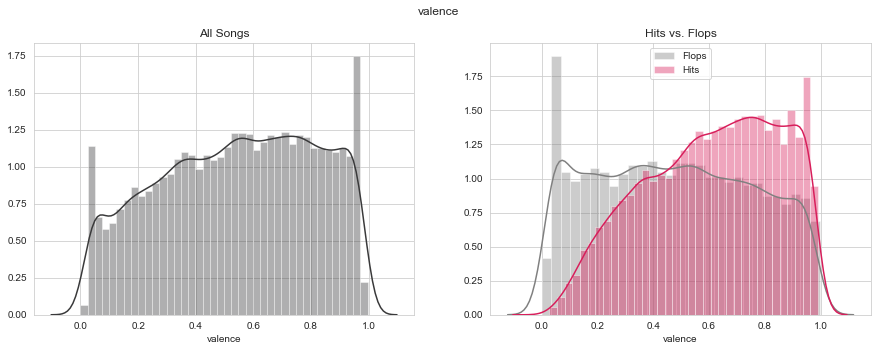

In [132]:
plot_histogram('valence')

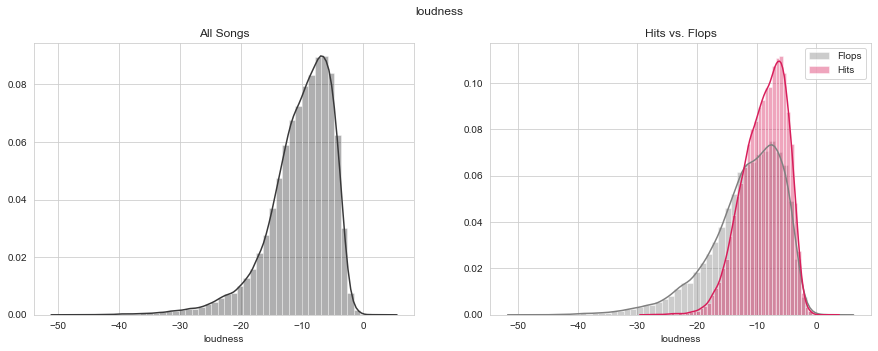

In [133]:
plot_histogram('loudness')

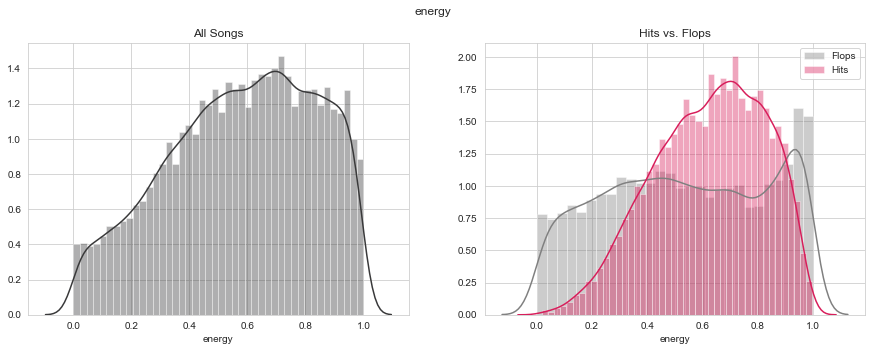

In [134]:
plot_histogram('energy')

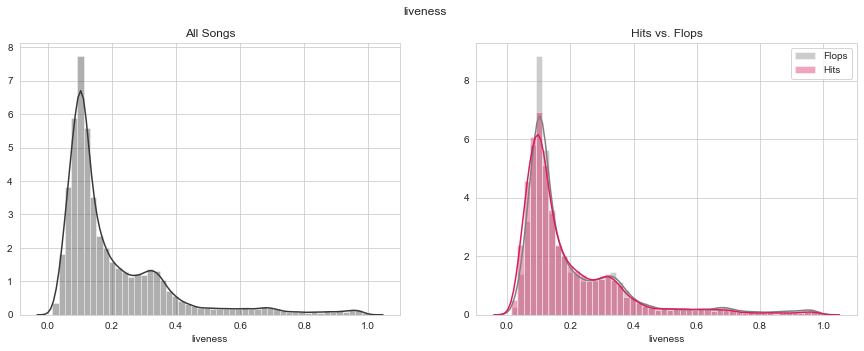

In [135]:
plot_histogram('liveness')

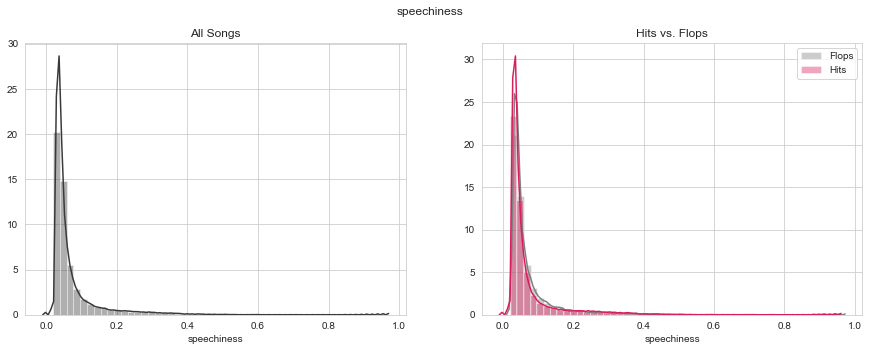

In [136]:
plot_histogram('speechiness')

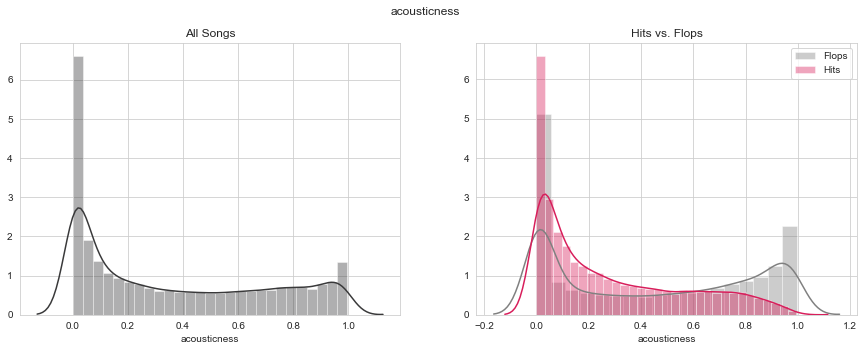

In [137]:
plot_histogram('acousticness')

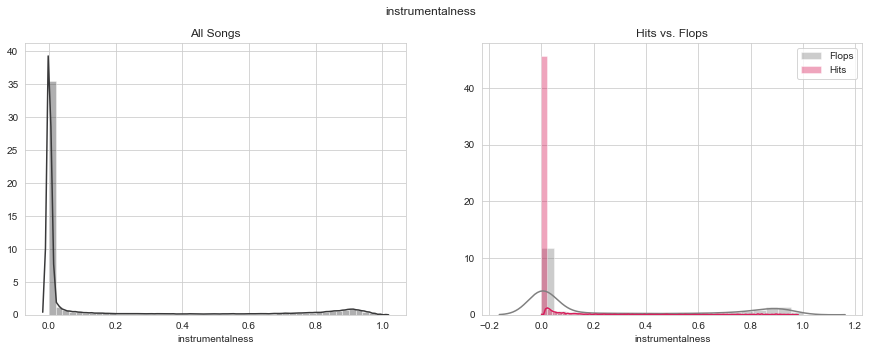

In [138]:
plot_histogram('instrumentalness')

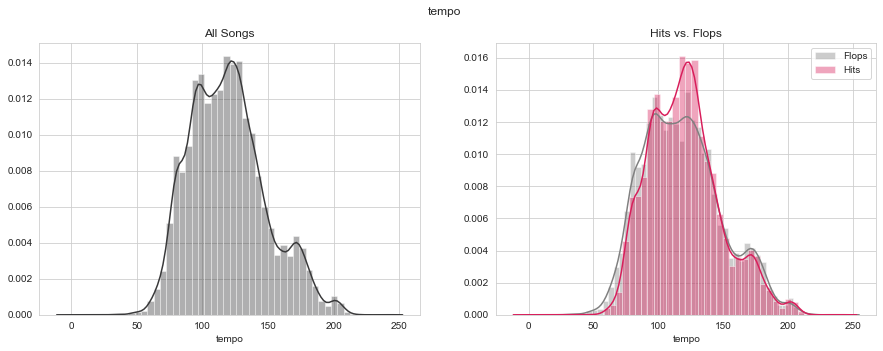

In [139]:
plot_histogram('tempo')

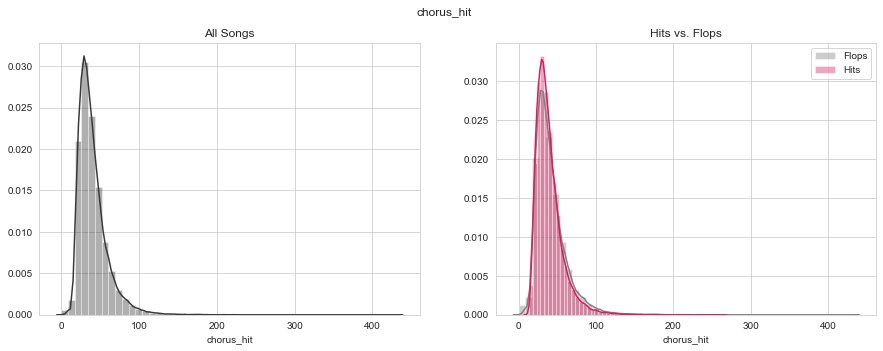

In [140]:
plot_histogram('chorus_hit')

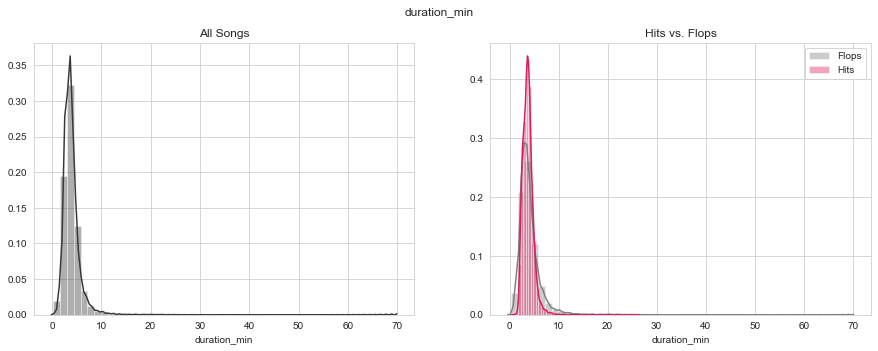

In [141]:
plot_histogram('duration_min')

## Analysis of Categorical Features

First look at Major vs. Minor Songs

Text(0.5, 0.95, 'Mode: 0 = Minor, 1 = Major')

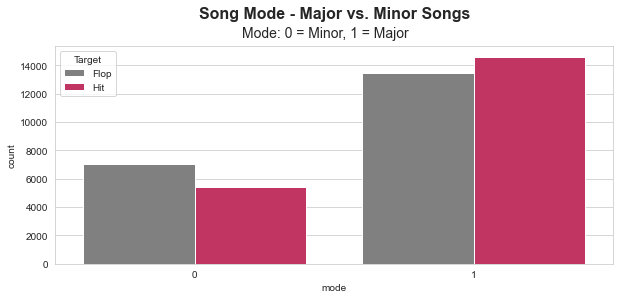

In [142]:
plt.figure(figsize=(10,4))
sns.countplot(x="mode", hue="target", data=df, palette={1:hit_pal,0:flop_pal})

plt.legend(title='Target', loc='upper left', labels=['Flop','Hit'])
plt.title('Song Mode - Major vs. Minor Songs', fontsize=16, fontweight='bold', y =1.1)
plt.suptitle('Mode: 0 = Minor, 1 = Major',fontsize=14, y=0.95)


Key is another categorical variable. Variable is encoded by "Pitch class".
https://en.wikipedia.org/wiki/Pitch_class

![](assets/pitch_class.png)

Text(0.5, 0.95, 'Key encoded by Pitch Class')

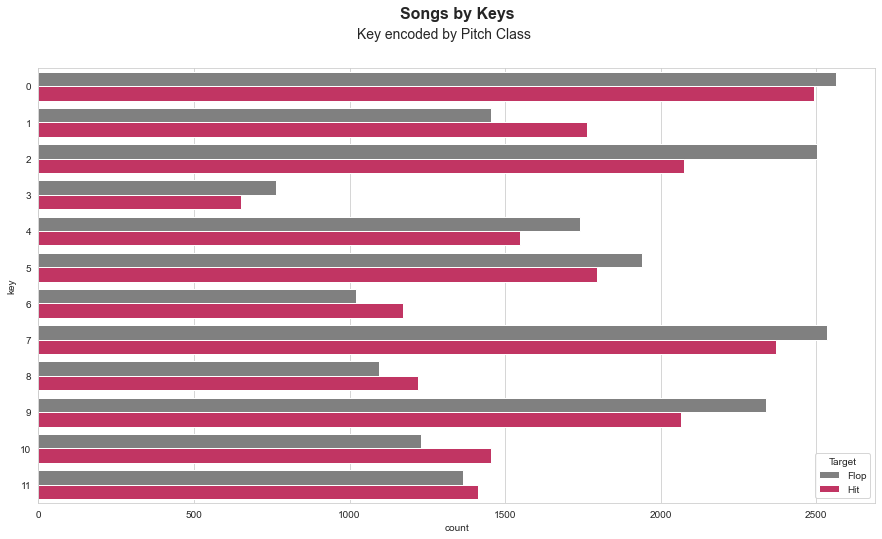

In [143]:
plt.figure(figsize=(15,8))
sns.countplot(y="key", hue="target", data=df, palette={1:hit_pal,0:flop_pal})

plt.legend(title='Target', loc='lower right', labels=['Flop','Hit'])
plt.title('Songs by Keys', fontsize=16, fontweight='bold', y =1.1)
plt.suptitle('Key encoded by Pitch Class',fontsize=14, y=0.95)


Hit Songs tend to be simpler compared to flop songs in terms of # of sections.

[Text(0.5, 1.0, 'Flops')]

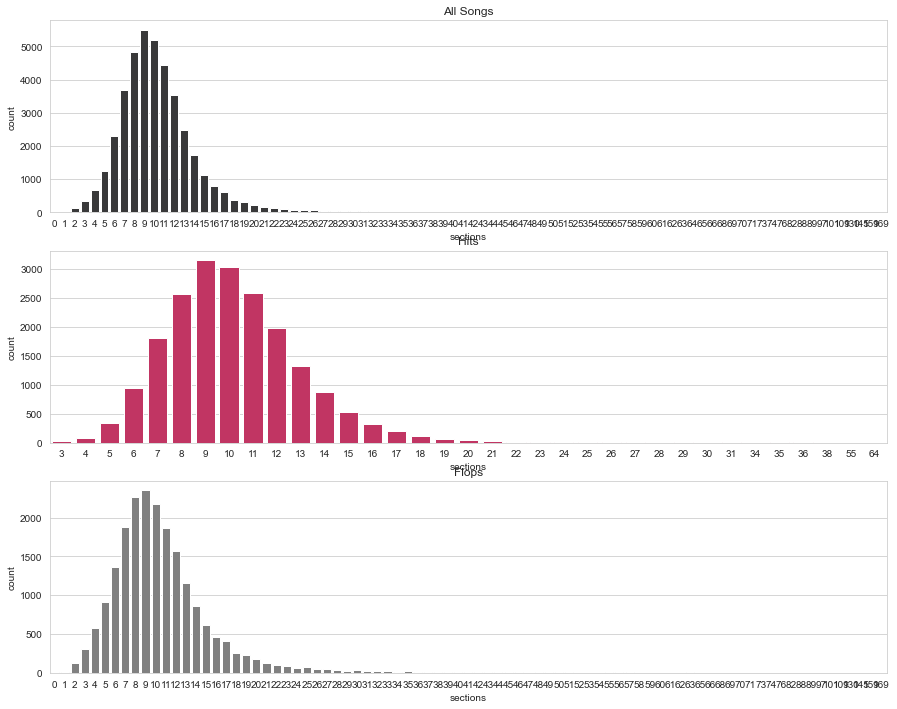

In [144]:

hits = df[df['target'] == 1]
flops = df[df['target'] == 0]

fig, ax = plt.subplots(3,1, figsize=(15,12))
sns.countplot(x="sections", data=df, color=all_pal, ax=ax[0]).set(title="All Songs")
sns.countplot(x="sections", data=hits, color=hit_pal, ax=ax[1]).set(title="Hits")
sns.countplot(x="sections", data=flops, color=flop_pal, ax=ax[2]).set(title="Flops")




## Extra EDA

### Extra - What are the top artists based on # of hits?

Text(0, 0.5, 'Artist')

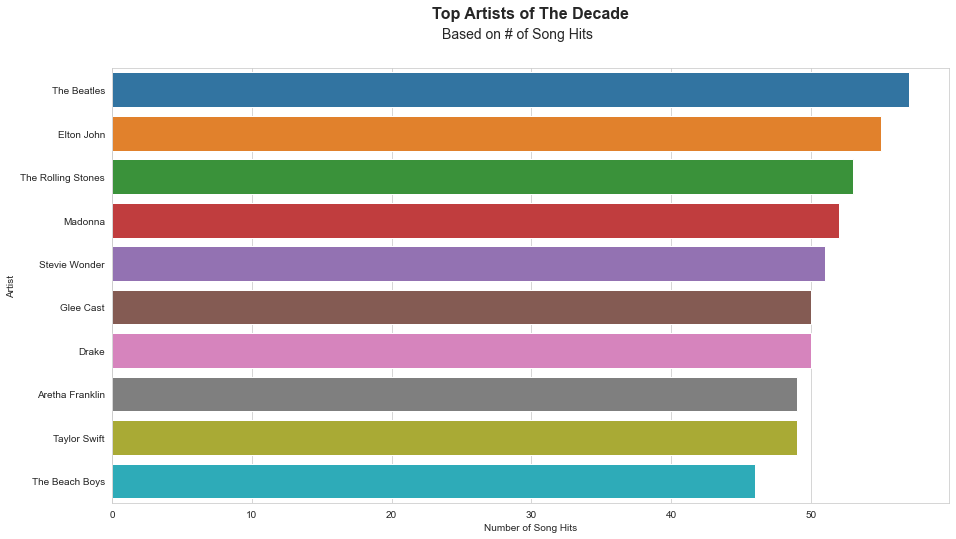

In [145]:
hits = df[df['target'] == 1]

hits_by_artist = hits[['artist','track']].groupby('artist',as_index=False).count().sort_values('track',ascending=False)
hits_by_artist=hits_by_artist.rename(columns = {'track':'total_hits'})

hits_by_artist.head(10)


plt.figure(figsize=(15,8))
plt.title('Top Artists of The Decade', fontsize=16, fontweight='bold', y =1.1)
plt.suptitle('Based on # of Song Hits',fontsize=14, y=0.95)
sns.set_style("darkgrid")
ax = sns.barplot(x='total_hits', y='artist', data=hits_by_artist.head(10))
ax.set_xlabel('Number of Song Hits')
ax.set_ylabel('Artist')

### Extra - Word Cloud for Hit Song Titles

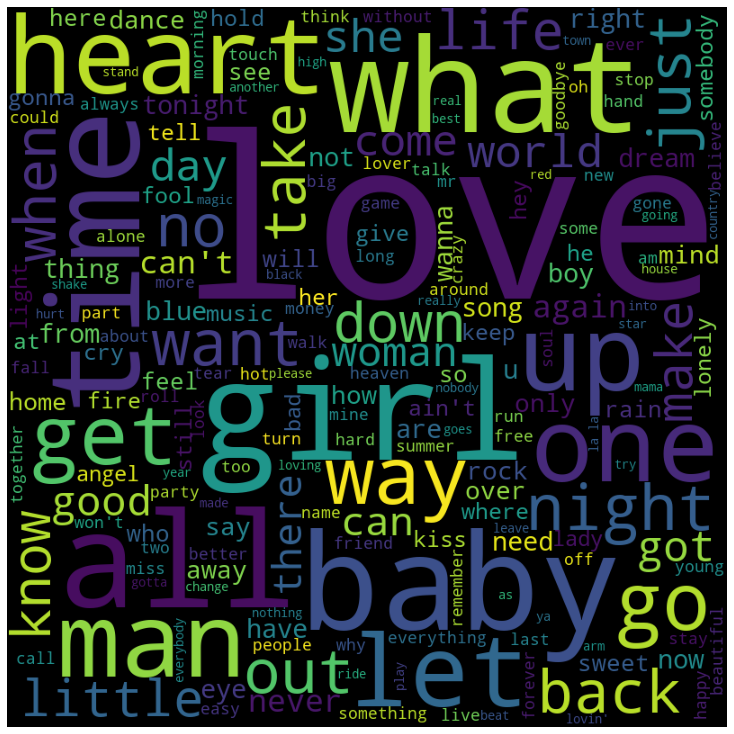

In [146]:
from wordcloud import WordCloud, STOPWORDS

comment_words = ''
for i in hits.track: 
    i = str(i) 
    separate = i.split() 
    for j in range(len(separate)): 
        separate[j] = separate[j].lower() 
    comment_words += " ".join(separate)+" "

# Creating the Word Cloud
stop_words = ['the',"i'll",'do',"be","don't",'like','i',"i'm","you're",'by','my','your','we','in','a','an','of','on','for','that','it','to','you','me','if','this','with','and','was','is']
final_wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words)

# Displaying the WordCloud                    
plt.figure(figsize = (10, 10), facecolor = None) 
plt.imshow(final_wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()